# Finetuning model for Title/Characters/Settings extraction

In [1]:
import json
import torch
import random
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq,
)
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
import evaluate
import os
import matplotlib.pyplot as plt
import nltk
import re
from typing import List, Tuple

# Make sure the required NLTK data packages are available
# Dynamically construct NLTK data directory relative to current working directory
nltk_data_dir = os.path.join(os.getcwd(), "venv", "nltk_data")

# Create directory if it doesn't exist
os.makedirs(nltk_data_dir, exist_ok=True)

nltk.download("punkt", download_dir=nltk_data_dir)
nltk.download('punkt_tab', download_dir=nltk_data_dir)
nltk.download("stopwords", download_dir=nltk_data_dir)

d:\Keven(Work)\dsa4213\final project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to d:\Keven(Work)\dsa4213\final
[nltk_data]     project\venv\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     d:\Keven(Work)\dsa4213\final project\venv\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     d:\Keven(Work)\dsa4213\final project\venv\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# set seed for reproducibility
def set_seed(seed=4213):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(4213)

In [3]:
# Config
# ==============================
TRAIN_FILE = "stories_with_outlines_first3000.jsonl"
OUTPUT_DIR = "./QA-LoRA-v2"
BASE_MODEL = "t5-small"
USE_LORA = True
MAX_INPUT_LENGTH = 768
MAX_TARGET_LENGTH = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# Data Preprocessing

In [4]:
# Read in raw data

print(f"Loading each event dataset: {TRAIN_FILE}")
# Read all lines as JSON
raw_data = []
with open(TRAIN_FILE, "r", encoding="utf-8") as f:
    for line in f:
        each_line = json.loads(line)
        # extract story text and reformat input
        story = each_line['story']
        question1 = "Question: Who are the characters in this story?"
        char_input = f"{question1} \nStory: {story}"
        question2 = "Question: What are all the settings in this story?"
        setting_input = f"{question2} \nStory: {story}"
        question3 = "Question: What is a good title for this story?"
        title_input = f"{question3} \nStory: {story}"
        # extract outline details: characters + settings
        outline = each_line['outline']
        char = ", ".join(outline.get("characters"))
        setting = ", ".join(outline.get("setting"))
        title = outline.get("title")
        # append to dataset
        raw_data.append({"instruction": char_input, "response": char})
        raw_data.append({"instruction": setting_input, "response": setting})
        raw_data.append({"instruction": title_input, "response": title})

raw_data[:3]  # preview first 3 entries 

Loading each event dataset: stories_with_outlines_first3000.jsonl


[{'instruction': 'Question: Who are the characters in this story? \nStory: Once upon a time, in a warm and sunny place, there was a big pit. A little boy named Tom liked to play near the pit. One day, Tom lost his red ball. He was very sad.\nTom asked his friend, Sam, to help him search for the ball. They looked high and low, but they could not find the ball. Tom said, "I think my ball fell into the pit."\nSam and Tom went close to the pit. They were scared, but they wanted to find the red ball. They looked into the pit, but it was too dark to see. Tom said, "We must go in and search for my ball."\nThey went into the pit to search. It was dark and scary. They could not find the ball. They tried to get out, but the pit was too deep. Tom and Sam were stuck in the pit. They called for help, but no one could hear them. They were sad and scared, and they never got out of the pit.',
  'response': 'Tom, Sam'},
 {'instruction': 'Question: What are all the settings in this story? \nStory: Once 

In [6]:
dataset = Dataset.from_list(raw_data)
dataset = dataset.train_test_split(test_size=0.01)

# Prepare tokenizer and model
print(f"Loading base model: {BASE_MODEL}")
base_model = AutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

dataset

Loading base model: t5-small


DatasetDict({
    train: Dataset({
        features: ['instruction', 'response'],
        num_rows: 8910
    })
    test: Dataset({
        features: ['instruction', 'response'],
        num_rows: 90
    })
})

In [7]:
# Preprocessing function
def preprocess_function(batch):
    model_inputs = tokenizer(
        batch["instruction"],
        max_length=MAX_INPUT_LENGTH,
        padding="max_length",
        truncation=True,
    )
    labels = tokenizer(
        text_target=batch["response"],
        max_length=MAX_TARGET_LENGTH,
        padding="max_length",
        truncation=True,
        )  
    # Replace pad token IDs with -100 so they’re ignored in cross-entropy loss
    labels["input_ids"] = [
        [(token if token != tokenizer.pad_token_id else -100) for token in label]
        for label in labels["input_ids"]
    ]
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenize the dataset
tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["instruction", "response"],
    desc="Tokenizing dataset",
)

Tokenizing dataset:   0%|          | 0/8910 [00:00<?, ? examples/s]

Tokenizing dataset: 100%|██████████| 90/90 [00:00<00:00, 1363.62 examples/s]


In [8]:
# Test current model with zero shot inference
from torch import no_grad

# use one example from test set
story = dataset['test'][67]["instruction"]
answer = dataset['test'][67]["response"]

# Tokenise input
inputs = tokenizer(story, return_tensors="pt", max_length=MAX_INPUT_LENGTH, truncation=True).to(DEVICE)
# Generate output and decode
with no_grad():
    outputs = base_model.generate(
        **inputs,
        max_new_tokens=MAX_TARGET_LENGTH,
        num_beams=4,
        early_stopping=True
    )
base_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

dashline = "-" * 80
print(dashline)
print("Story:")
print(story)
print(dashline)
print("Expected output:")  
print(answer)
print(dashline)
print("Model Output:")
print(base_output)
print(dashline)

--------------------------------------------------------------------------------
Story:
Question: Who are the characters in this story? 
Story: Once upon a time, in a big forest, there lived a little girl named Lily. She loved to play with her toys and equipment. One day, she found a rare, shiny stone while playing outside.
Lily showed the stone to her friend, Tom. "Guess what I found!" she said. "Wow, that's a rare stone!" Tom replied. They were both very happy and excited.
Together, they decided to make a special place for the rare stone. They used their equipment to dig a small hole and put the stone inside. They covered it with leaves and branches. Lily and Tom promised to always remember where their rare stone was hidden. And they played and laughed together, having lots of fun in the big forest.
--------------------------------------------------------------------------------
Expected output:
Lily, Tom
-------------------------------------------------------------------------------

# PEFT model using LoRA
(skip the cells in this section if not finetuning)

In [18]:
# LoRA configuration
if USE_LORA:
    print("Applying LoRA adapter for lightweight fine-tuning...")
    lora_config = LoraConfig(
        r=32,
        lora_alpha=128,
        target_modules=["q", "v"],
        lora_dropout=0.05,
        bias="none",
        task_type="SEQ_2_SEQ_LM",
    )
lora_model = get_peft_model(base_model, lora_config)
lora_model.print_trainable_parameters()

print(f"Using device: {DEVICE}")
lora_model = lora_model.to(DEVICE)

# PEFT Training configuration
peft_training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    auto_find_batch_size=True,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    learning_rate=3e-5,
    fp16=torch.cuda.is_available(),
    predict_with_generate=True,
    report_to="none",  # disable wandb/tensorboard
    save_strategy="steps",  
    save_steps=50,          
    save_total_limit=3,     
    logging_strategy="epoch",
)

# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=lora_model
)

# PEFT Trainer setup
peft_trainer = Trainer(  
    model=lora_model,
    args=peft_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator,
    processing_class=tokenizer,
)

Applying LoRA adapter for lightweight fine-tuning...
trainable params: 1,179,648 || all params: 61,686,272 || trainable%: 1.9123
Using device: cuda


In [19]:
# Initiate training

print("Starting training...")
# Resume only if checkpoint exists
resume_checkpoint = None
last_checkpoint_dir = os.path.join(OUTPUT_DIR, "checkpoint-last")
if os.path.isdir(last_checkpoint_dir):
    resume_checkpoint = last_checkpoint_dir
    print(f"Resuming from checkpoint: {resume_checkpoint}")
else:
    print("No existing checkpoint found — starting fresh training.")

# Else start training
peft_trainer.train(resume_from_checkpoint=resume_checkpoint)

# Save the final model with training logs
print(f"Saving LoRA fine-tuned model to {OUTPUT_DIR}")
lora_model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
peft_trainer.save_state()

Starting training...
No existing checkpoint found — starting fresh training.


Step,Training Loss
279,2.723700
558,1.809600
837,1.678600


Saving LoRA fine-tuned model to ./QA-LoRA-v2


# Models Testing and Comparison

In [9]:
# Now we can test and compare the models on the same example
def load_model_for_inference(directory, device=DEVICE):
    if directory==BASE_MODEL:
        model = AutoModelForSeq2SeqLM.from_pretrained(directory)
        tokenizer = AutoTokenizer.from_pretrained(directory)
    else:
        config = PeftConfig.from_pretrained(directory)
        base_model = AutoModelForSeq2SeqLM.from_pretrained(config.base_model_name_or_path)
        model = PeftModel.from_pretrained(base_model, directory)
        tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
    model = model.to(device)
    model.eval()  # ensure inference mode
    print(f"Loaded {directory} on device: {device}")
    return model, tokenizer

# function to generate outputs
def generate_output(text_input, model, tokenizer, device=DEVICE):
    # generate input
    inputs = tokenizer(text_input, return_tensors="pt").to(device)
    # then generate output
    with torch.inference_mode():
        output = tokenizer.decode(
        model.generate(**inputs, max_new_tokens=MAX_TARGET_LENGTH)[0],
        skip_special_tokens=True
    )
    return output

t5_small, t5s_tokenizer = load_model_for_inference(BASE_MODEL)
lora_v1, lv1_tokenizer = load_model_for_inference("./QA-LoRA-v1")
lora_v2, lv2_tokenizer = load_model_for_inference("./QA-LoRA-v2")

Loaded t5-small on device: cuda
Loaded ./QA-LoRA-v1 on device: cuda
Loaded ./QA-LoRA-v2 on device: cuda


In [10]:
# Display summaries
print("-" * 100)
print("Actual Text:")
print(story)
print("-" * 100)
print("Expected summary:")  
print(answer)
print("-" * 100)
print("t5_small Output summary:")
print(generate_output(story, t5_small, t5s_tokenizer))
print("-" * 100)
print("lora_v1 Output summary:")
print(generate_output(story, lora_v1, lv1_tokenizer))
print("-" * 100)
print("lora_v2 Output summary:")
print(generate_output(story, lora_v2, lv2_tokenizer))
print("-" * 100)

----------------------------------------------------------------------------------------------------
Actual Text:
Question: Who are the characters in this story? 
Story: Once upon a time, in a big forest, there lived a little girl named Lily. She loved to play with her toys and equipment. One day, she found a rare, shiny stone while playing outside.
Lily showed the stone to her friend, Tom. "Guess what I found!" she said. "Wow, that's a rare stone!" Tom replied. They were both very happy and excited.
Together, they decided to make a special place for the rare stone. They used their equipment to dig a small hole and put the stone inside. They covered it with leaves and branches. Lily and Tom promised to always remember where their rare stone was hidden. And they played and laughed together, having lots of fun in the big forest.
----------------------------------------------------------------------------------------------------
Expected summary:
Lily, Tom
--------------------------------

In [11]:
# prepare the eval dataset to be used for rouge evaluation
original_summaries = []
base_model_predictions = []
lora1_model_predictions = []
lora2_model_predictions = []

print("Generating predictions...")
for item in dataset['test']:    # replace test_subset with eval_data
    # original summary list
    original_summaries.append(item["response"])
    # predictions
    base1_output = generate_output(item["instruction"], t5_small, t5s_tokenizer)
    base_model_predictions.append(base1_output)
    lora1_output = generate_output(item["instruction"], lora_v1, lv1_tokenizer)
    lora1_model_predictions.append(lora1_output)
    lora2_output = generate_output(item["instruction"], lora_v2, lv2_tokenizer)
    lora2_model_predictions.append(lora2_output)

Generating predictions...


Token indices sequence length is longer than the specified maximum sequence length for this model (769 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (769 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (769 > 512). Running this sequence through the model will result in indexing errors


In [12]:
# combine into dataframe
df = pd.DataFrame({
    "Original answer": original_summaries,
    "Base Model Prediction": base_model_predictions,
    "LoRA-v1 Model Prediction": lora1_model_predictions,
    "LoRA-v2 Model Prediction": lora2_model_predictions
})

df.head(10)

,Original answer,Base Model Prediction,LoRA-v1 Model Prediction,LoRA-v2 Model Prediction
0,Max and the Shiny Magnet,Max and Sam watched the boat with the shiny ma...,shiny,a hairy dog
1,"Tom, Tom's mom",Tom and his mom made a great sandwich together...,Tom's mom,Tom's mom
2,Tim and the Orange,Tim had a red ball that he loved to play with....,Tim,Tim's Orange
3,The Lesson of the Shiny Diamond,Bob's diamond was a red bird. Tom wanted a shi...,Bob,Bob the Green Bird
4,Tim and the Big Bag of Popcorn,Tim loved popcorn. Tim forgot his promise to s...,Tim,Tim's Big Bag of Popcorn
5,"Tom's home, the tree",Tom and his friends saved the cat. They were a...,a tree,a tree
6,Izzy and Tommy's Careful Play,Izzy was very careful when she played because ...,Izzy,Izzy and Tommy's Big Garden
7,Tim and the Whistle Dogs,"Tim was surprised and happy. Now, he had many ...",Tim,Tim's Dog
8,The Compassionate Goose,Goose: What is a good title for this story?,Goose,The Goose
9,"Sue, Tim",Sue was very happy with her blocks. Tim was we...,Sue,"Sue, Tim, Tim"


In [13]:
# Perform ROUGE evaluation
def compute_rouge_score(predictions, references):
    rouge = evaluate.load("rouge")
    results = rouge.compute(
        predictions=predictions, 
        references=references,
        use_aggregator=True,
        use_stemmer=True,
    )
    return results

# Clean text for fair comparison
original_summaries = [s.strip().lower() for s in original_summaries]
base_model_predictions = [p.strip().lower() for p in base_model_predictions]
lora_model1_predictions = [p.strip().lower() for p in lora1_model_predictions]
lora_model2_predictions = [p.strip().lower() for p in lora2_model_predictions]

# Compute ROUGE scores
base_model_results = compute_rouge_score(base_model_predictions, original_summaries)
lora1_model_results = compute_rouge_score(lora1_model_predictions, original_summaries)
lora2_model_results = compute_rouge_score(lora2_model_predictions, original_summaries)
all_results = {
    "t5-small Model": base_model_results,
    "LoRA-v1 Model": lora1_model_results,
    "LoRA-v2 Model": lora2_model_results,
}

# Compare relative percentage differences in rouge scores over base model
def display_percentage_difference(base_results, new_results, model_name):
    print(f"Relative Percentage Differences in ROUGE scores for {model_name} over Base Model:")
    for key in base_results.keys():
        base_score = base_results[key] * 100  # convert to percentage
        new_score = new_results[key] * 100  # convert to percentage
        relative_diff = ((new_score - base_score) / base_score) * 100
        print(f"{key}: {relative_diff:.2f}%")
    print(dashline)

#display_percentage_difference(base_model_results, lora1_model_results, "flan-T5 Model")
#display_percentage_difference(base_model_results, lora2_model_results, "LoRA-v2 Model")

In [15]:
print("ROUGE scores for various models' answer against ground truth:")
results_df = pd.DataFrame.from_dict(all_results, orient='index')
results_df.head()

ROUGE scores for various models' answer against ground truth:


,rouge1,rouge2,rougeL,rougeLsum
t5-small Model,0.179773,0.032921,0.170074,0.170642
LoRA-v1 Model,0.457033,0.076098,0.447999,0.449476
LoRA-v2 Model,0.621968,0.363206,0.621053,0.623734


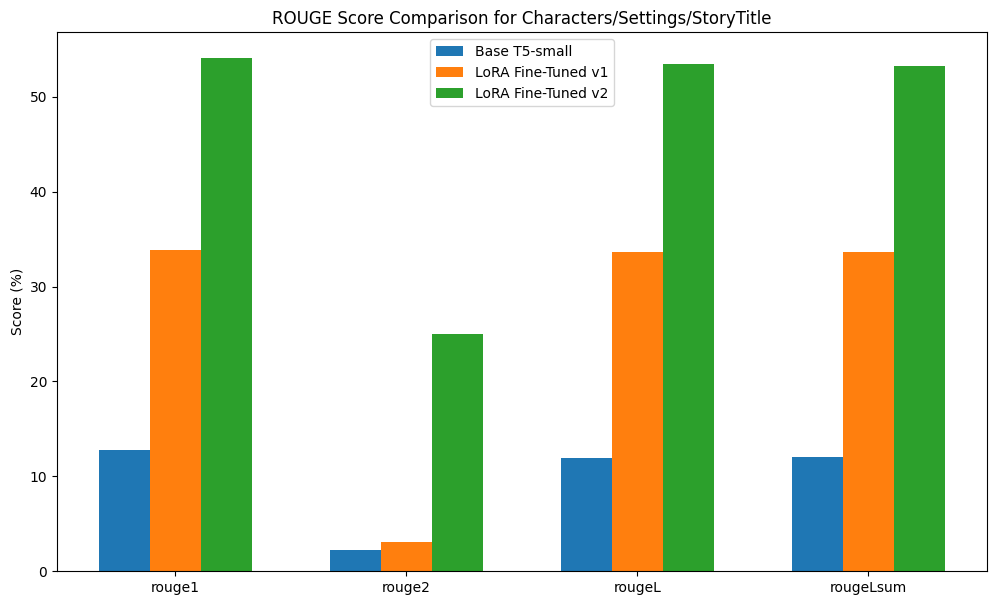

In [25]:
# Plot visuals
keys = list(base_model_results.keys())
base_vals = [base_model_results[k] * 100 for k in keys]
lora1_vals = [lora1_model_results[k] * 100 for k in keys]
lora2_vals = [lora2_model_results[k] * 100 for k in keys]

x = np.arange(len(keys))  # the label locations
width = 0.22              # width of each bar

plt.figure(figsize=(12, 7))
plt.bar(x - width, base_vals, width, label='Base T5-small')
plt.bar(x , lora1_vals, width, label='LoRA Fine-Tuned v1')
plt.bar(x + width, lora2_vals, width, label='LoRA Fine-Tuned v2')

plt.xticks(x, keys)
plt.title('ROUGE Score Comparison for Characters/Settings/StoryTitle')
plt.ylabel('Score (%)')
plt.legend()
plt.show()

In [17]:
# helper function to normalise prediction answers
def normalize_text(text: str) -> str:
    """Lowercase, remove punctuation, extra spaces."""
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text)     # remove extra whitespace
    return text.strip()

# custom f1_score calculator
def f1_score_list(prediction: str, reference: str) -> Tuple[float, float, float]:
    """
    Computes token/item-level F1 between prediction and reference.
    Returns: (precision, recall, f1)
    """
    # Normalize and split by comma
    pred_items = [normalize_text(x) for x in prediction.split(",")]
    ref_items = [normalize_text(x) for x in reference.split(",")]

    # Convert to sets for matching
    pred_set = set(pred_items)
    ref_set = set(ref_items)

    # Compute precision, recall
    if len(pred_set) == 0 or len(ref_set) == 0:
        return 0.0, 0.0, 0.0

    true_positives = len(pred_set & ref_set)
    precision = true_positives / len(pred_set)
    recall = true_positives / len(ref_set)
    
    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1

In [18]:
# Evaluate using f1-score since Characters and Settings are list of elements
# the scores are not reflective of overall data since Title generally has 0 f1-score

def evaluate_dataset(predictions: List[str], references: List[str]):
    """
    Evaluates lists of predictions and references.
    Returns average precision, recall, F1.
    """
    precisions, recalls, f1s = [], [], []

    for pred, ref in zip(predictions, references):
        p, r, f1 = f1_score_list(pred, ref)
        precisions.append(p)
        recalls.append(r)
        f1s.append(f1)

    avg_precision = sum(precisions) / len(precisions)
    avg_recall = sum(recalls) / len(recalls)
    avg_f1 = sum(f1s) / len(f1s)

    return {"precision": f"{avg_precision:.4f}", "recall": f"{avg_recall:.4f}", "f1": f"{avg_f1:.4f}"}


base_f1_results = evaluate_dataset(base_model_predictions, original_summaries)
lorav1_f1_results = evaluate_dataset(lora_model1_predictions, original_summaries)
lorav2_f1_results = evaluate_dataset(lora_model2_predictions, original_summaries)
all_f1results = {
    "Base T5-small Model": base_f1_results,
    "LoRA-v1 Model": lorav1_f1_results,
    "LoRA-v2 Model": lorav2_f1_results
}
# Display results
print("F1-scores for predicted answers against ground truth:")
df2 = pd.DataFrame.from_dict(all_f1results, orient='index')
df2

F1-scores for predicted answers against ground truth:


,precision,recall,f1
Base T5-small Model,0.0074,0.0083,0.0076
LoRA-v1 Model,0.1556,0.0815,0.1037
LoRA-v2 Model,0.3907,0.3611,0.3678
